In [10]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from catboost import CatBoostClassifier
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
import joblib
import os
import sys
import shutil
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
from collections import defaultdict

## Adding path for custom python modules and importing them

In [11]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

In [12]:
from utilities import bs_calibrate, bs_results, utils

# DATA PREPRATION

In [13]:
df = pd.read_csv("../dibh_clinical_only/original_training_data.csv")
data_day1 = df[df['day'] == 1]
X = data_day1.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y = data_day1['DIBH_Y0N1']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.30, random_state=42)

df_internal_val = pd.read_csv("../dibh_clinical_only/final_internal_validation13052024.csv")
data_day1_val = df_internal_val[df_internal_val['day'] == 1]
X_int_val = data_day1_val.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y_int_val = data_day1_val['DIBH_Y0N1']

categorical_features = ['al_N0_Y1', 'surgery_BCS1MRM2', 'chemo_No0_Adj1_NAdj2', 'comorb_no0_cardio1_others2']
continuous_features = ['age', 'BMI', 'ul_amp', 'll_amp', 'average_amp', 'ahd']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, continuous_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# HYPERPARAMETER OPTIMIZATION

In [ ]:
def objective(trial):
    params = {
    'iterations': trial.suggest_int('iterations', 50, 1000),
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
    'depth': trial.suggest_int('depth', 1, 16),
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
    'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
    'border_count': trial.suggest_int('border_count', 32, 255),
    'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
    'rsm': trial.suggest_float('rsm', 0.5, 1.0),
    'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
    'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    'od_wait': trial.suggest_int('od_wait', 10, 50),
    'verbose': 0  # Suppress output
}
    catboost_clf = make_pipeline(preprocessor, CatBoostClassifier(**params))
    cv_roc_auc = cross_val_score(catboost_clf, X_t, y_t, cv=10, scoring='roc_auc').mean()
    return cv_roc_auc


In [5]:
storage_name = "sqlite:///db.sqlite3"
# sampler = TPESampler(seed=72)
# # Random seeds - 42,50,58,66,72
# study = optuna.create_study(direction='maximize', sampler=sampler, storage=storage_name, study_name="CatBoost_one_day_assessment_final04")
# study.optimize(objective, n_trials=1000)

In [6]:
loaded_study = optuna.create_study(study_name="CatBoost_one_day_assessment_final02", storage=storage_name, load_if_exists=True)
best_params = loaded_study.best_params

[I 2024-08-03 10:20:10,429] Using an existing study with name 'CatBoost_one_day_assessment_final02' instead of creating a new one.


In [7]:
best_params['verbose'] = 0

## Bootstraping and Calibration

In [14]:
# For Gradient Boosting
top_models_gb, results_gb, calibration_data_gb = bs_calibrate.bootstrap_model_evaluation(
    X_t, y_t, X_v, y_v, preprocessor, CatBoostClassifier, best_params
)

Bootstrap sample no. 25 ------ Finished
Bootstrap sample no. 50 ------ Finished
Bootstrap sample no. 75 ------ Finished
Bootstrap sample no. 100 ------ Finished
Bootstrap sample no. 125 ------ Finished
Bootstrap sample no. 150 ------ Finished
Bootstrap sample no. 175 ------ Finished
Bootstrap sample no. 200 ------ Finished
Bootstrap sample no. 225 ------ Finished
Bootstrap sample no. 250 ------ Finished
Bootstrap sample no. 275 ------ Finished
Bootstrap sample no. 300 ------ Finished
Bootstrap sample no. 325 ------ Finished
Bootstrap sample no. 350 ------ Finished
Bootstrap sample no. 375 ------ Finished
Bootstrap sample no. 400 ------ Finished
Bootstrap sample no. 425 ------ Finished
Bootstrap sample no. 450 ------ Finished
Bootstrap sample no. 475 ------ Finished
Bootstrap sample no. 500 ------ Finished
Bootstrap sample no. 525 ------ Finished
Bootstrap sample no. 550 ------ Finished
Bootstrap sample no. 575 ------ Finished
Bootstrap sample no. 600 ------ Finished
Bootstrap sample no

## Saving Data

In [15]:
joblib.dump(top_models_gb, '../Catboost_Models/top_models_cb.joblib')
joblib.dump(results_gb, '../Catboost_Models/results.joblib')
joblib.dump(calibration_data_gb, '../Catboost_Models/calibration_data_cb.joblib')

['../Catboost_Models/calibration_data_cb.joblib']

## Plotting Calibration curves

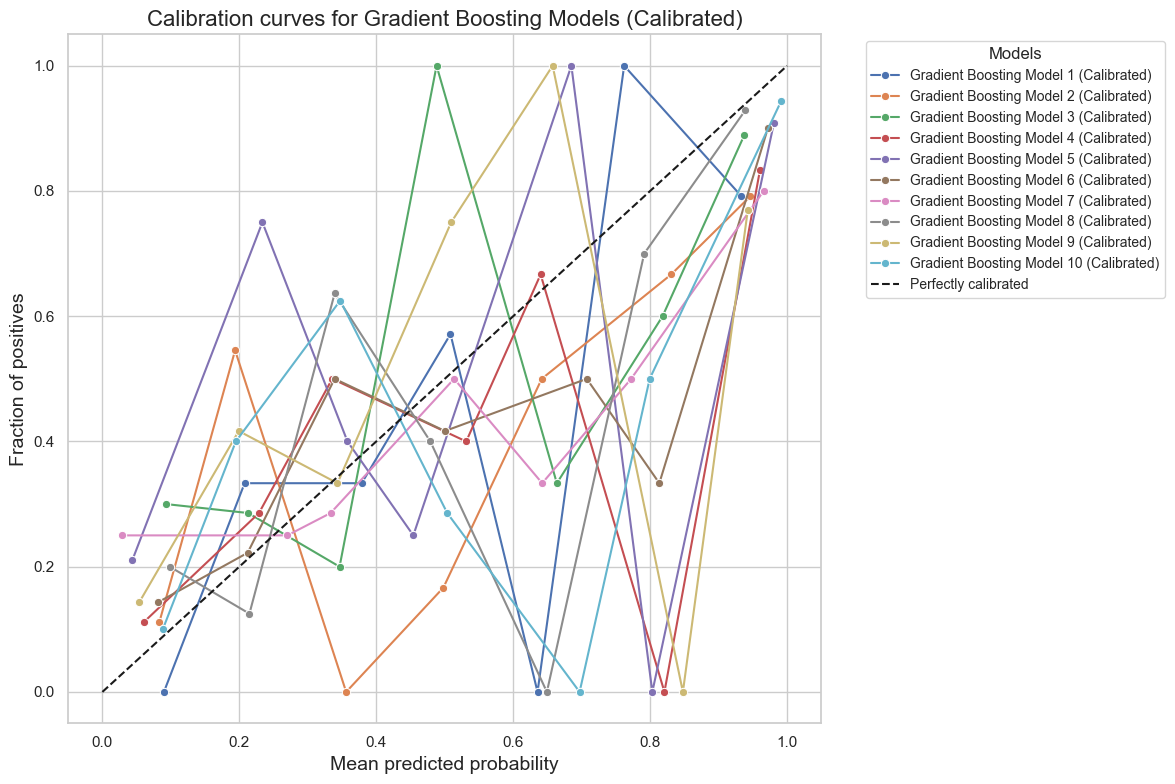

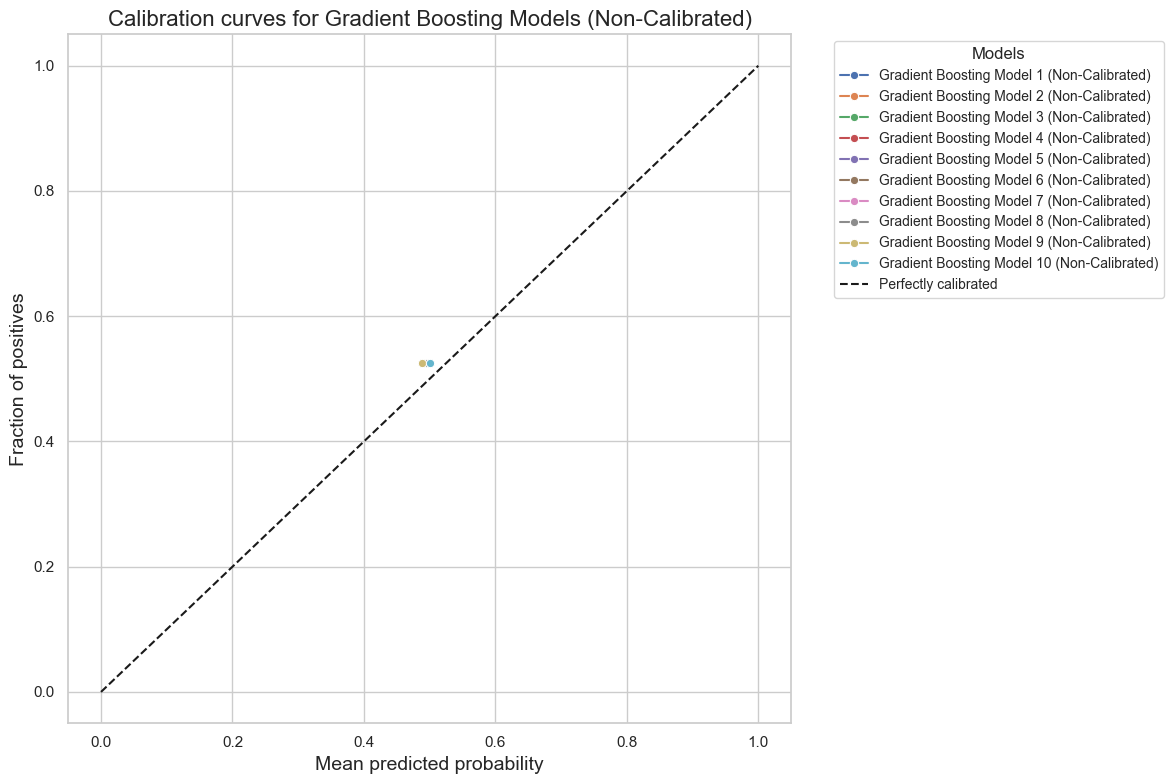

In [16]:
# Assuming calibration_data_gb and calibration_data_cat have the top 10 predicted probabilities
# for Gradient Boosting models
loaded_calibration_data = joblib.load('../Catboost_Models/calibration_data_cb.joblib')
# Example: Plotting calibration curves for top 10 Gradient Boosting models
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_calibrated'], n_bins=7, model_label="Gradient Boosting", calibrated=True)
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_non_calibrated'], n_bins=7, model_label="Gradient Boosting", calibrated=False)

## Extract feature importances and save them in a csv file

In [17]:
# Save to CSV
df_importances = utils.save_feature_importances_to_csv(filename='feature_importances.csv', 
                                                       model_name_prefix='gb', 
                                                       top_models_path='../Catboost_Models/top_models_cb.joblib')

Data saved to - feature_importances.csv


## Plot feature importance

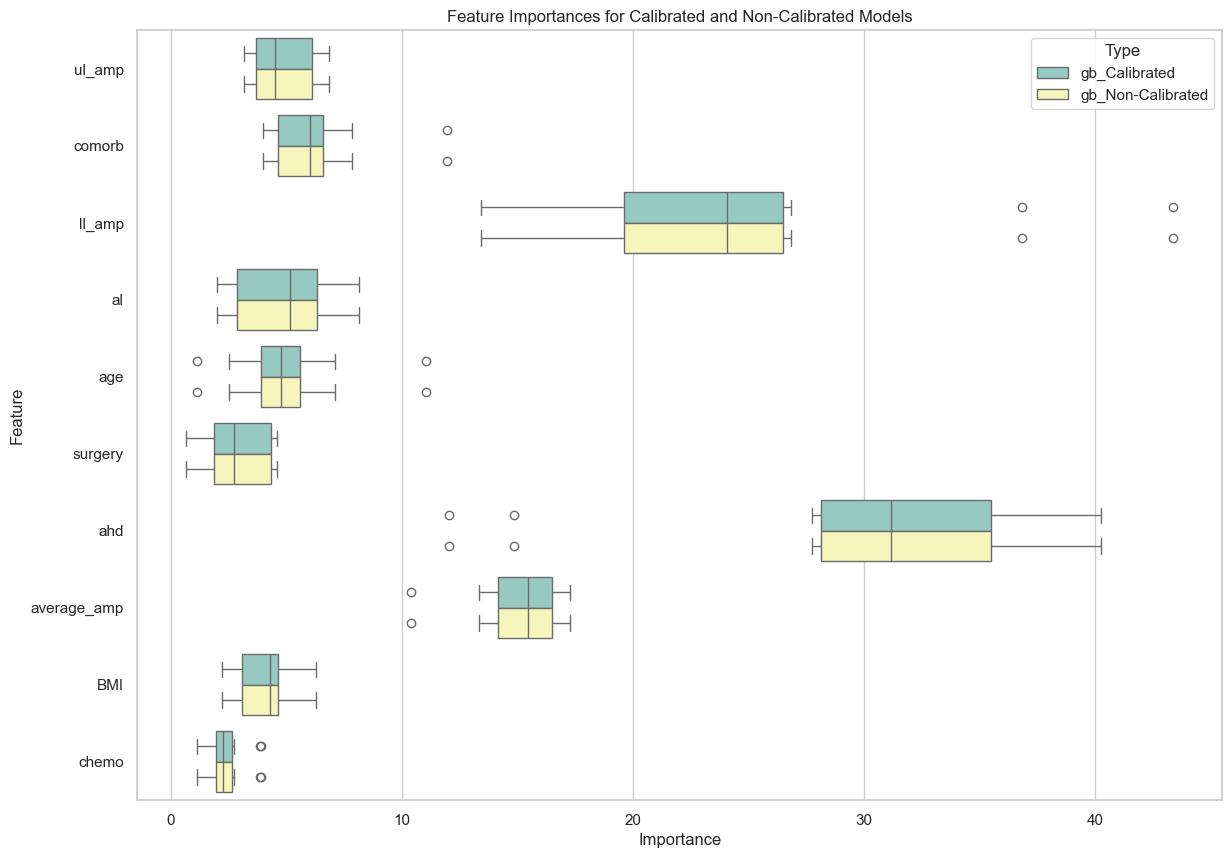

In [18]:
# Box plot
plt.figure(figsize=(14, 10))
sns.boxplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set3')
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

## Store the results for models into a csv file

In [19]:
loaded_results = joblib.load('../GB_Models/results.joblib')
calibrated_summary, non_calibrated_summary = bs_results.get_results(loaded_results)

Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.737623   0.824318  0.650969  0.719356  0.760115
std           0.020108   0.064758  0.094215  0.038260  0.019317
min           0.655738   0.675000  0.437500  0.595745  0.668103
max           0.819672   0.950000  0.937500  0.830769  0.830819
95% CI lower  0.698212   0.697393  0.466307  0.644366  0.722253
95% CI upper  0.777034   0.951244  0.835630  0.794345  0.797976

Non-Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.736623   0.826882  0.645219  0.716808  0.757860
std           0.020744   0.064216  0.093934  0.038947  0.020747
min           0.672131   0.666667  0.437500  0.583333  0.681034
max           0.819672   0.952381  0.937500  0.840580  0.820043
95% CI lower  0.695964   0.701019  0.461107  0.640472  0.717196
95% CI upper  0.777282   0.952744  0.829330  0.793145  0.798524


In [20]:
filename='../saved_models/final_results.csv'
model_name = 'CB'
bs_results.save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

'Data saved to ../saved_models/final_results.csv'

In [23]:
loaded_calibration_data['top_predicted_proba_non_calibrated']

[array([0.52196593, 0.5462835 , 0.46548699, 0.47408871, 0.513494  ,
        0.48474854, 0.48830123, 0.53260659, 0.54759336, 0.4753532 ,
        0.5192328 , 0.48528207, 0.54657981, 0.5017432 , 0.51726606,
        0.50578435, 0.49878123, 0.53231145, 0.52934155, 0.4683733 ,
        0.48063523, 0.51722874, 0.46730849, 0.49893027, 0.46803203,
        0.47289264, 0.49296687, 0.49735855, 0.46501381, 0.47335356,
        0.51807898, 0.46083331, 0.53071678, 0.48878211, 0.47823901,
        0.48965204, 0.54354094, 0.50576642, 0.47489536, 0.4903244 ,
        0.52335289, 0.47151843, 0.48265711, 0.52837144, 0.53346601,
        0.49225583, 0.54890185, 0.46877539, 0.53421983, 0.46794459,
        0.46881374, 0.50324366, 0.49425943, 0.49040057, 0.46447344,
        0.4824006 , 0.52160978, 0.52476629, 0.51378937, 0.49747952,
        0.52718974]),
 array([0.5049263 , 0.54549934, 0.46885177, 0.48257068, 0.51992145,
        0.49457641, 0.46900271, 0.53079329, 0.53662279, 0.48384918,
        0.52699653, 0.4873

In [ ]:
# Initialize lists to store results
top_models = []
fraction_of_positives_calibrated_list = []
mean_predicted_value_calibrated_list = []
fraction_of_positives_non_calibrated_list = []
mean_predicted_value_non_calibrated_list = []
results = []

# Number of bins for more granularity
n_bins_non_calibrated = 5
n_bins_calibrated = 5

for i in range(1000):
    X_resampled, y_resampled = resample(X_t, y_t)
    X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2)

    # Non-calibrated model
    catboost_pipeline = make_pipeline(preprocessor, CatBoostClassifier(**best_params))
    catboost_pipeline.fit(X_train_resampled, y_train_resampled)
    y_proba_non_calibrated = catboost_pipeline.predict_proba(X_v)[:, 1]

    # Calibrated model
    best_catboost_pipeline = make_pipeline(preprocessor, CatBoostClassifier(**best_params))
    best_catboost_pipeline.fit(X_train_resampled, y_train_resampled)  # Fit the underlying pipeline first
    model = CalibratedClassifierCV(best_catboost_pipeline, method='sigmoid', cv=10)
    model.fit(X_train_resampled, y_train_resampled)
    y_proba_calibrated = model.predict_proba(X_v)[:, 1]

    # Verify that the models are fitted
    try:
        check_is_fitted(catboost_pipeline.named_steps['catboostclassifier'])
    except NotFittedError:
        print(f"CatBoostClassifier in non-calibrated pipeline is not fitted. Skipping this model.")
        continue

    try:
        check_is_fitted(model)
    except NotFittedError:
        print(f"CalibratedClassifierCV is not fitted. Skipping this model.")
        continue

    # Calibration curves for non-calibrated model
    fraction_of_positives_non_calibrated, mean_predicted_value_non_calibrated = calibration_curve(y_v, y_proba_non_calibrated, n_bins=n_bins_non_calibrated)
    if len(fraction_of_positives_non_calibrated) == n_bins_non_calibrated:
        print(f"FRACTION OF POSITIVE NON CALIBRATED: {fraction_of_positives_non_calibrated}")
        fraction_of_positives_non_calibrated_list.append(fraction_of_positives_non_calibrated)
        mean_predicted_value_non_calibrated_list.append(mean_predicted_value_non_calibrated)
    else:
        print(f"Non-calibrated model - Unexpected number of bins: {len(fraction_of_positives_non_calibrated)}")

    # Calibration curves for calibrated model
    fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_v, y_proba_calibrated, n_bins=n_bins_calibrated)
    if len(fraction_of_positives_calibrated) == n_bins_calibrated:
        print(f"FRACTION OF POSITIVE CALIBRATED: {fraction_of_positives_calibrated}")
        fraction_of_positives_calibrated_list.append(fraction_of_positives_calibrated)
        mean_predicted_value_calibrated_list.append(mean_predicted_value_calibrated)
    else:
        print(f"Calibrated model - Unexpected number of bins: {len(fraction_of_positives_calibrated)}")

    # ROC curve and other metrics for calibrated model
    fpr, tpr, thresholds = roc_curve(y_v, y_proba_calibrated)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_optimal = (y_proba_calibrated >= optimal_threshold).astype(int)

    # ROC curve and other metrics for non-calibrated model
    fpr_non_calibrated, tpr_non_calibrated, thresholds_non_calibrated = roc_curve(y_v, y_proba_non_calibrated)
    roc_auc_non_calibrated = auc(fpr_non_calibrated, tpr_non_calibrated)
    optimal_idx_non_calibrated = np.argmax(tpr_non_calibrated - fpr_non_calibrated)
    optimal_threshold_non_calibrated = thresholds_non_calibrated[optimal_idx_non_calibrated]
    y_pred_optimal_non_calibrated = (y_proba_non_calibrated >= optimal_threshold_non_calibrated).astype(int)

    # Extract feature importances and names for non-calibrated model
    pipeline_non_calibrated = catboost_pipeline
    catboost_non_calibrated = pipeline_non_calibrated.named_steps['catboostclassifier']
    feature_importances_non_calibrated = catboost_non_calibrated.feature_importances_
    preprocessor = pipeline_non_calibrated.named_steps['columntransformer']
    feature_names = preprocessor.get_feature_names_out()

    # Aggregate importances for one-hot encoded features for non-calibrated model
    aggregated_importances_non_calibrated = defaultdict(float)
    for feature_name, importance in zip(feature_names, feature_importances_non_calibrated):
        original_feature_name = feature_name.split('__')[1].split('_')[0] if 'cat__' in feature_name else feature_name.split('__')[1]
        aggregated_importances_non_calibrated[original_feature_name] += importance

    # Convert aggregated importances to a sorted list of tuples for non-calibrated model
    sorted_importances_non_calibrated = sorted(aggregated_importances_non_calibrated.items(), key=lambda x: x[1], reverse=True)

    # Extract feature importances and names for calibrated model
    # print(dir(model))
    pipeline_calibrated = model.estimator
    catboost_calibrated = pipeline_calibrated.named_steps['catboostclassifier']
    feature_importances_calibrated = catboost_calibrated.feature_importances_

    # Aggregate importances for one-hot encoded features for calibrated model
    aggregated_importances_calibrated = defaultdict(float)
    for feature_name, importance in zip(feature_names, feature_importances_calibrated):
        original_feature_name = feature_name.split('__')[1].split('_')[0] if 'cat__' in feature_name else feature_name.split('__')[1]
        aggregated_importances_calibrated[original_feature_name] += importance

    # Convert aggregated importances to a sorted list of tuples for calibrated model
    sorted_importances_calibrated = sorted(aggregated_importances_calibrated.items(), key=lambda x: x[1], reverse=True)

    model_info = {
        'model_calibrated': model,
        'fpr_calibrated': fpr,
        'tpr_calibrated': tpr,
        'thresholds_calibrated': thresholds,
        'roc_auc_calibrated': roc_auc,
        'optimal_threshold_calibrated': optimal_threshold,
        'accuracy_calibrated': accuracy_score(y_v, y_pred_optimal),
        'precision_calibrated': precision_score(y_v, y_pred_optimal),
        'recall_calibrated': recall_score(y_v, y_pred_optimal),
        'f1_score_calibrated': f1_score(y_v, y_pred_optimal),
        'confusion_matrix_calibrated': confusion_matrix(y_v, y_pred_optimal),
        'classification_report_calibrated': classification_report(y_v, y_pred_optimal),
        'feature_importances_calibrated': sorted_importances_calibrated,
        'model_non_calibrated': catboost_pipeline,
        'fpr_non_calibrated': fpr_non_calibrated,
        'tpr_non_calibrated': tpr_non_calibrated,
        'thresholds_non_calibrated': thresholds_non_calibrated,
        'roc_auc_non_calibrated': roc_auc_non_calibrated,
        'optimal_threshold_non_calibrated': optimal_threshold_non_calibrated,
        'accuracy_non_calibrated': accuracy_score(y_v, y_pred_optimal_non_calibrated),
        'precision_non_calibrated': precision_score(y_v, y_pred_optimal_non_calibrated),
        'recall_non_calibrated': recall_score(y_v, y_pred_optimal_non_calibrated),
        'f1_score_non_calibrated': f1_score(y_v, y_pred_optimal_non_calibrated),
        'confusion_matrix_non_calibrated': confusion_matrix(y_v, y_pred_optimal_non_calibrated),
        'classification_report_non_calibrated': classification_report(y_v, y_pred_optimal_non_calibrated),
        'feature_importances_non_calibrated': sorted_importances_non_calibrated
    }

    # Add the non-model info to results
    model_info_without_model = {key: value for key, value in model_info.items() if not key.startswith('model')}
    results.append(model_info_without_model)

    if len(top_models) < 10:
        top_models.append(model_info)
    else:
        min_index = min(range(len(top_models)), key=lambda x: (top_models[x]['roc_auc_calibrated'], top_models[x]['recall_calibrated']))
        if roc_auc > top_models[min_index]['roc_auc_calibrated']:
            top_models[min_index] = model_info

    if (i + 1) % 25 == 0:
        print(f"Bootstrap sample no. {i + 1} ------ Finished")



In [ ]:
# Save the dictionary
joblib.dump(top_models, 'top_models_with_importances.joblib')
joblib.dump(results, 'results.joblib')

In [ ]:
# Verify the calibration lists before calculating the means
print(f"Number of calibrated entries: {len(fraction_of_positives_calibrated_list)}")
print(f"Number of non-calibrated entries: {len(fraction_of_positives_non_calibrated_list)}")

# Calculate the mean fraction of positives and mean predicted values for calibrated models
mean_fraction_of_positives_calibrated = np.mean(fraction_of_positives_calibrated_list, axis=0)
mean_mean_predicted_value_calibrated = np.mean(mean_predicted_value_calibrated_list, axis=0)

# Calculate the mean fraction of positives and mean predicted values for non-calibrated models
mean_fraction_of_positives_non_calibrated = np.mean(fraction_of_positives_non_calibrated_list, axis=0)
mean_mean_predicted_value_non_calibrated = np.mean(mean_predicted_value_non_calibrated_list, axis=0)

# Debugging: print the means
print(f"Calibrated mean fraction of positives: {mean_fraction_of_positives_calibrated}")
print(f"Calibrated mean predicted value: {mean_mean_predicted_value_calibrated}")
print(f"Non-calibrated mean fraction of positives: {mean_fraction_of_positives_non_calibrated}")
print(f"Non-calibrated mean predicted value: {mean_mean_predicted_value_non_calibrated}")

# Interpolate to a common set of points for smoother comparison
common_points = np.linspace(0, 1, 100)
interp_fraction_of_positives_calibrated = np.interp(common_points, mean_mean_predicted_value_calibrated, mean_fraction_of_positives_calibrated)
interp_fraction_of_positives_non_calibrated = np.interp(common_points, mean_mean_predicted_value_non_calibrated, mean_fraction_of_positives_non_calibrated)

# Plot the calibration curves
plt.figure(figsize=[8, 6])
plt.plot(common_points, interp_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(common_points, interp_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping")
plt.legend()
plt.show()

In [ ]:
calibrated_summary, non_calibrated_summary = bs_results.get_results(results)

In [ ]:
# Example usage
filename='../saved_models/final_results.csv'
model_name = 'catboost'
bs_results.save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

# BOOTSTRAP SAMPLING and TRAINING

In [ ]:
top_models = []
fraction_of_positives_calibrated_list = []
mean_predicted_value_calibrated_list = []
fraction_of_positives_non_calibrated_list = []
mean_predicted_value_non_calibrated_list = []
results = []

for i in range(1000):
    X_resampled, y_resampled = resample(X_t, y_t)
    X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2)

    catboost_pipeline = make_pipeline(preprocessor, CatBoostClassifier(**best_params))
    catboost_pipeline.fit(X_train_resampled, y_train_resampled)
    y_proba_non_calibrated = catboost_pipeline.predict_proba(X_v)[:, 1]

    best_catboost_pipeline = make_pipeline(preprocessor, CatBoostClassifier(**best_params))
    model = CalibratedClassifierCV(best_catboost_pipeline, method='sigmoid', cv=10)
    model.fit(X_train_resampled, y_train_resampled)
    y_proba_calibrated = model.predict_proba(X_v)[:, 1]

    fraction_of_positives_non_calibrated, mean_predicted_value_non_calibrated = calibration_curve(y_v, y_proba_non_calibrated, n_bins=6)
    if len(fraction_of_positives_non_calibrated) == 6:
        fraction_of_positives_non_calibrated_list.append(fraction_of_positives_non_calibrated)
        mean_predicted_value_non_calibrated_list.append(mean_predicted_value_non_calibrated)

    fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_v, y_proba_calibrated, n_bins=6)
    if len(fraction_of_positives_calibrated) == 6:
        fraction_of_positives_calibrated_list.append(fraction_of_positives_calibrated)
        mean_predicted_value_calibrated_list.append(mean_predicted_value_calibrated)

    fpr, tpr, thresholds = roc_curve(y_v, y_proba_calibrated)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_optimal = (y_proba_calibrated >= optimal_threshold).astype(int)

    model_info = {
        'model': model,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'roc_auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'accuracy': accuracy_score(y_v, y_pred_optimal),
        'precision': precision_score(y_v, y_pred_optimal),
        'recall': recall_score(y_v, y_pred_optimal),
        'f1_score': f1_score(y_v, y_pred_optimal),
        'confusion_matrix': confusion_matrix(y_v, y_pred_optimal),
        'classification_report': classification_report(y_v, y_pred_optimal)
    }

    model_info_without_model = {key: value for key, value in model_info.items() if key != 'model'}
    results.append(model_info_without_model)

    if len(top_models) < 10:
        top_models.append(model_info)
    else:
        min_index = min(range(len(top_models)), key=lambda x: (top_models[x]['roc_auc'], top_models[x]['recall']))
        if roc_auc > top_models[min_index]['roc_auc']:
            top_models[min_index] = model_info

    if (i + 1) % 25 == 0:
        print(f"Bootstrap sample no. {i + 1} ------ Finished")

# Plotting the calibration curve

In [ ]:
# Calculate the mean calibration curve

mean_fraction_of_positives_calibrated = np.mean(fraction_of_positives_calibrated_list, axis=0)
mean_mean_predicted_value_calibrated = np.mean(mean_predicted_value_calibrated_list, axis=0)
mean_fraction_of_positives_non_calibrated = np.mean(fraction_of_positives_non_calibrated_list, axis=0)
mean_mean_predicted_value_non_calibrated = np.mean(mean_predicted_value_non_calibrated_list, axis=0)

# Plot the calibration curves
plt.figure(figsize=[8, 6])
plt.plot(mean_mean_predicted_value_calibrated, mean_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(mean_mean_predicted_value_non_calibrated, mean_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping")
plt.legend()
plt.show()

In [ ]:
# RESULTS
df_results = pd.DataFrame(results)

metric_summary = df_results[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].agg(['mean', 'std', 'min', 'max'])
metric_summary.loc['95% CI lower'] = metric_summary.loc['mean'] - 1.96 * metric_summary.loc['std']
metric_summary.loc['95% CI upper'] = metric_summary.loc['mean'] + 1.96 * metric_summary.loc['std']

print(metric_summary)

# Saving top 10 models

In [ ]:
model_folder_path = '../saved_models/one_day_catboost_top10'

if os.path.exists(model_folder_path):
    shutil.rmtree(model_folder_path)
os.makedirs(model_folder_path)

for i, m in enumerate(top_models):
    model_path = os.path.join(model_folder_path, f'top_model_{i+1}.joblib')
    joblib.dump(m['model'], model_path)

preprocessor_path = os.path.join(model_folder_path, 'preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)

print(f"All top models have been saved to folder: {model_folder_path}")
print(f"Preprocessor has been saved as {preprocessor_path}")

# Create Ensemble Model

In [ ]:
class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        return probabilities
    
    def predict(self, X):
        predictions = np.array([model.predict_proba(X)[:, 1] >= threshold for model, threshold in self.models]).astype(int).T
        final_predictions = mode(predictions, axis=1)[0].flatten()
        return final_predictions

ensemble_models = [(m['model'], m['optimal_threshold']) for m in top_models]
ensemble_classifier = ThresholdedEnsembleClassifier(ensemble_models)

joblib_file = '../saved_models/one_day_catboost_top10/ensemble_classifier_catboost.joblib'
joblib.dump(ensemble_classifier, joblib_file)

# Load the ensemble classifier from a .joblib file

In [ ]:
ensemble_classifier = joblib.load(joblib_file)
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

print("Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))

# Calibrating the ensemble model

In [ ]:
class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
        self.calibrator = None
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        if self.calibrator:
            probabilities = self.calibrator.transform(probabilities)
        return probabilities
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        predictions = (probabilities >= 0.5).astype(int)
        return predictions
    
    def calibrate(self, X, y):
        probabilities = self.predict_proba(X)
        self.calibrator = IsotonicRegression(out_of_bounds='clip')
        self.calibrator.fit(probabilities, y)
        return self

ensemble_models = [(m['model'], m['optimal_threshold']) for m in top_models]
ensemble_classifier = ThresholdedEnsembleClassifier(ensemble_models)

# Save the ensemble classifier before calibration
joblib_file = '../saved_models/one_day_catboost_top10/ensemble_classifier_catboost.joblib'
joblib.dump(ensemble_classifier, joblib_file)

# Calibrate the ensemble classifier on the prospective internal validation data
ensemble_classifier.calibrate(X_int_val, y_int_val)

# Save the calibrated ensemble classifier
joblib_file_calibrated = '../saved_models/one_day_catboost_top10/calibrated_ensemble_classifier_catboost.joblib'
joblib.dump(ensemble_classifier, joblib_file_calibrated)

# Now we can use the calibrated ensemble classifier to make predictions

In [ ]:
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

# Evaluate the ensemble performance on prospective data as needed
print("Calibrated Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Calibrated Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Calibrated Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Calibrated Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Calibrated Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))

# Result for publication

In [ ]:
class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        return probabilities
    
    def predict(self, X):
        predictions = np.array([model.predict_proba(X)[:, 1] >= threshold for model, threshold in self.models]).astype(int).T
        final_predictions = mode(predictions, axis=1)[0].flatten()
        return final_predictions

In [ ]:
joblib_file = '../saved_models/one_day_catboost_top10/ensemble_classifier_catboost.joblib'
ensemble_classifier = joblib.load(joblib_file)

In [ ]:

y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

print("Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))

In [ ]:
results_df = pd.DataFrame({
    'actual_outcome': y_int_val,
    'predicted_probability': y_proba
})

# Save the DataFrame to a CSV file
results_df.to_csv('../saved_models/one_day_catboost_top10/catboost_predictions.csv', index=False)

In [ ]:
results_df